# 0. Import data
The train and test split has already been done in the dataset, so I'll just import them from different csv files.

In [1]:
# load the zip file
from zipfile import ZipFile

with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
    zObject.extractall()

In [2]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)  # summarize y_train into one vector

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


In [3]:
y_train_labels.head()

0      Average
1         High
2      Average
3    Very High
4         High
dtype: object

## Add new data

In [4]:
# Truncated and cleaned up region data to merge (Week 4 folder)
countrydata=pd.read_csv("newcountryvars.csv")

countrydata.head()

,country_name,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni
0,India,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799
1,Nigeria,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264
2,Mexico,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680
3,Pakistan,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074
4,Bangladesh,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722


In [5]:
# Join new data to X_train and X_test by taking "Country or region" from first table and "country_name" from 2nd table.

X_train = pd.merge(X_train, countrydata, how='left', left_on=["Country or region"], right_on=["country_name"])
X_test= pd.merge(X_test, countrydata, how='left', left_on=["Country or region"], right_on=["country_name"])

# only keep one key
X_train.drop(columns=['country_name'], inplace=True)
X_test.drop(columns=["country_name"], inplace=True)

In [6]:
X_train.head(1)

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni
0,Peru,0.96,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.0,32165485.0,22.7,0.739749,74.814,13.38634,9.01347,11294.84033


# 1. EDA

Text(0.5, 1.0, 'Distributin of Happiness Level')

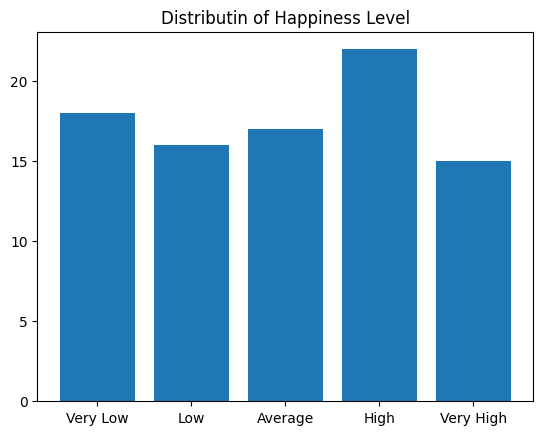

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot distribution of y variable
happiness_order = ['Very Low', 'Low', 'Average', 'High', 'Very High']
happiness_count = y_train_labels.value_counts()
plt.bar(x=happiness_order, height=happiness_count[happiness_order])
plt.title("Distributin of Happiness Level")

<ipython-input-8-a74a0eb08af4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_try["target"] = y_train_labels


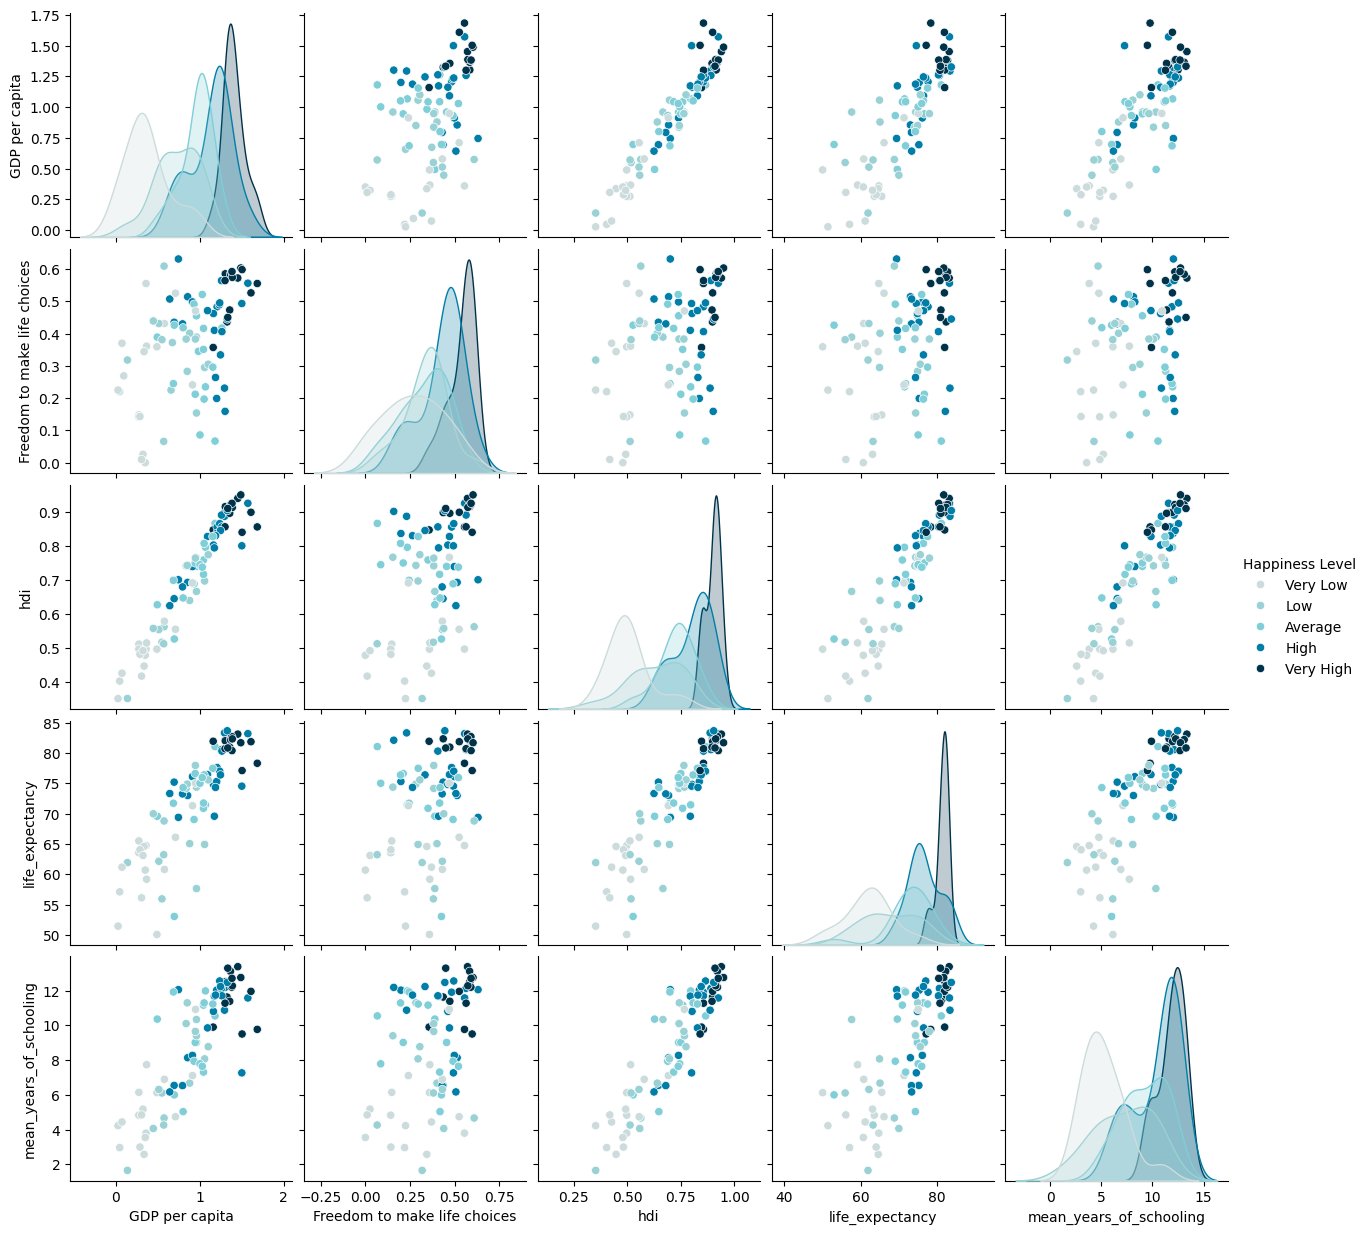

In [8]:
# select columns from X_train and add y_trai
df_try = X_train[["GDP per capita", "Freedom to make life choices", "hdi", "life_expectancy", "mean_years_of_schooling"]]
df_try["target"] = y_train_labels

# pairplot the relations between columns, the color indicates different happiness levels
level_palette = ["#ccdbdc", "#9ad1d4", "#80ced7", "#007ea7", "#003249"]
pairplot = sns.pairplot(df_try, hue='target', hue_order=happiness_order, palette=level_palette)
pairplot._legend.set_title('Happiness Level')

 With all the features that are intuitively considered to be positively correlated with happiness, the pairplot does roughly show this tendency.


# 2. Preprocessing

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create the preprocessing pipelines for both numeric and categorical data.
numeric_features = X_train.drop(["Country or region", "name", "region", "sub-region"], axis=1)  ## Drop all the non-numerical features from X_train
numeric_features = numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='constant', fill_value=0)), ## Is this good enough?
     ('scaler', StandardScaler())]) # You will need to describe why this is being done in the next cell

categorical_features = ['region', 'sub-region']

# Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown= 'error'))])

# Final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocess = preprocessor.fit(X_train)

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

# 3. Establish the model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

model = RandomForestClassifier()

param_grid = {
    "n_estimators": np.arange(50, 201, 50),
    "max_depth": np.arange(5, 21, 5),
    "min_samples_split": np.arange(2, 5),
    "min_samples_leaf": np.arange(1, 5),
    }

gridmodel = GridSearchCV(model, param_grid, cv=5)

gridmodel.fit(preprocessor(X_train), y_train_labels)

print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))

best mean cross-validation score: 0.683
best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}


# 4. Save and Submit the model to aishare

In [13]:
#Set credentials using modelshare.org username/password
import aimodelshare as ai

apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"
ai.aws.set_credentials(apiurl=apiurl)

Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.


In [14]:
# Initiate Competition
mycompetition= ai.Competition(apiurl)

In [15]:
# save the preprocessor to aimodelshare
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [17]:
# Save the RF model to local ONNX
from aimodelshare.aimsonnx import model_to_onnx
from skl2onnx.common.data_types import FloatTensorType

feature_count = preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))] # Insert correct number of preprocessed features

onnx_model = ai.aimsonnx.model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [18]:
# Generate predicted values
prediction_labels = gridmodel.predict(preprocessor(X_test))
gridmodel_filepath = "model.onnx"
preprocessor_filepath="preprocessor.zip"

# Submit to Competition Leaderboard
mycompetition.submit_model(model=gridmodel_filepath,
                           prediction_submission=prediction_labels,
                           preprocessor=preprocessor_filepath)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 1147

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.ai/detail/model:3164
